In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/MSCRED-Pytorch-main
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MSCRED-Pytorch-main
/content/drive/MyDrive/Colab Notebooks/MSCRED-Pytorch-main


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import notebook
from torch.utils.data import DataLoader, TensorDataset
from src.utils import calculate_signature_matrix_dataset, generate_dataset
from src.mscred import MSCRED
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
import pandas_datareader as wb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 25.6 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [4]:
!pip install -U finance-datareader
import FinanceDataReader as fdr
import pandas as pd
import pandas_datareader as wb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

start="2001"
end="2022-06-24"
for index,stock in enumerate(['KS11']):
    
    #stock_data=fdr.DataReader(stock,start)
    stock_data=fdr.DataReader('KS11', start, end)
    close=stock_data.loc[:,'Close']
    #Volume=stock_data.loc[:,'Volume']
    #stock_data.columns=[stock+"Close",stock+"Volume"]
    if index==0:
        close_data1=pd.DataFrame(close)
        #vol_data1=pd.DataFrame(Volume)
    else:
        close_data1=pd.concat([close_data,pd.DataFrame(close)],axis=1)
        #vol_data1=pd.concat([vol_data,pd.DataFrame(Volume)],axis=1)

import FinanceDataReader as fdr
stock_k=['JP225','CSI300','STOXX50','DJI','KS11','USD/KRW','VIX']
for index,i in enumerate(stock_k):
    stock_data=fdr.DataReader(i, start, end)
    close=stock_data.loc[:,'Close']
    #Volume=stock_data.loc[:,'Volume']
    #print(close)
    #break
    
    #stock_data.columns=[stock+"Close",stock+"Volume"]
    if index==0:
        close_data=pd.DataFrame(close)
        #vol_data=pd.DataFrame(Volume)
    else:
        close_data=pd.concat([close_data,pd.DataFrame(close)],axis=1)
        #vol_data=pd.concat([vol_data,pd.DataFrame(Volume)],axis=1)

In [ ]:
close_data=close_data.ffill()

In [ ]:
data1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data1.csv')
data2=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data2.csv')
csv_data=pd.concat([data1,data2],axis=0)#.ffill()#.dropna()
csv_data["DATE"]#.astype('str')
csv_data["DATE"]=pd.to_datetime(csv_data["DATE"])
csv_data=csv_data.set_index("DATE")
csv_data=pd.concat([csv_data,close_data1],axis=1)#.ffill()#.dropna()
csv_data=csv_data.reindex( columns = ['NKY Index','SHSZ300 Index','SX5E Index','INDU Index','Close','KRW Curncy','VIX Index','LMCADY Comdty','USYC2Y10 Index'])

In [ ]:
csv_data=csv_data.drop(['LMCADY Comdty','USYC2Y10 Index'],axis=1)

In [ ]:
new_data=close_data.ffill().loc[csv_data.dropna().index[-1]:,:].iloc[1:,:]

new_data
new_data.columns=['NKY Index','SHSZ300 Index','SX5E Index','INDU Index','Close','KRW Curncy','VIX Index']

csv_data=pd.concat([csv_data.loc[:csv_data.dropna().index[-1],:],new_data],axis=0)
csv_data.columns=['NKY Index','SHSZ300 Index','SX5E Index','INDU Index','KS','KRW Curncy','VIX Index']
csv_data=csv_data.reindex( columns = ['NKY Index','SHSZ300 Index','SX5E Index','INDU Index','KS','KRW Curncy','VIX Index'])

In [ ]:
csv_data=csv_data.dropna()

In [ ]:
csv_data

,NKY Index,SHSZ300 Index,SX5E Index,INDU Index,KS,KRW Curncy,VIX Index
2002-01-04,10871.49,1316.46,3820.42,10259.74,747.72,1302.50,20.45
2002-01-07,10942.36,1302.08,3754.42,10197.05,751.48,1301.50,21.94
2002-01-08,10695.60,1292.71,3724.04,10150.55,734.76,1308.50,21.83
2002-01-09,10663.98,1272.65,3722.98,10094.09,751.61,1309.50,22.13
2002-01-10,10538.43,1281.26,3666.36,10067.86,728.23,1312.00,22.36
...,...,...,...,...,...,...,...
2022-06-20,25771.22,4330.43,3469.83,29885.08,2391.03,1291.54,31.03
2022-06-21,26246.31,4325.57,3494.00,30531.77,2408.93,1291.72,30.19
2022-06-22,26149.55,4270.62,3464.64,30481.88,2342.81,1297.58,28.95
2022-06-23,26171.25,4343.88,3436.29,30678.15,2314.32,1299.81,29.05


In [ ]:
def EMA(df_stock,col): # input : 주가 dataframe 
    
    num_periods = 20 # 평균을 계산하는 기간(n): 20 days
    K = 2 / (num_periods + 1) # 평활화(smoothing) 상수
    ema_p = 0
    ema_values_list = [] # 계산된 EMA값 저장을 위한 리스트
    
    close_price = df_stock.loc[:,col]
    
    
    for price in close_price:
    
        if ema_p == 0: # 첫 번째 관찰값 EMA = 현재 주가

            ema_p = price

        else:

            ema_p = (price - ema_p) * K + ema_p

        ema_values_list.append(ema_p)
    
    
    df_stock = df_stock.assign(EMA = pd.Series(ema_values_list, index = df_stock.index))
    ema = df_stock['EMA']

    fig = plt.figure()
    ax1 = fig.add_subplot(111, ylabel = 'stock price in $')
    close_price.plot(ax=ax1, color='b', lw=2, legend=True)
    ema.plot(ax=ax1, color='orange', lw=2, legend=True)
    plt.show()
    return ema

In [ ]:
def MACD(df_stock,col):
    
    num_periods_fast = 10 # EMA_fast 기간 = 10 days
    K_fast = 2 / (num_periods_fast + 1) # 평활화 벡터 = 2/11
    ema_fast = 0

    num_periods_slow = 40 # EMA_slow 기간 = 40 days
    K_slow = 4 / (num_periods_slow + 1) # 평활화 벡터 = 4/11
    ema_slow = 0

    num_periods_macd = 20 # EMA_macd 기간 = 20 days
    K_macd = 4 / (num_periods_macd + 1) # 평활화 벡터 = 4/11
    ema_macd = 0

    ema_fast_values_list = []
    ema_slow_values_list = []
    macd_values_list = []
    macd_signals_list = []

    macd_histograms_list = [] # MACD_histogram = MACD - MACD_signal
    
    close_price = df_stock[col]
    
    
    for price in close_price:
    
        if ema_fast == 0: # 첫 번째 관찰값

            ema_fast = price
            ema_slow = price

        else:
            
            ema_fast = (price - ema_fast) * K_fast + ema_fast
            ema_slow = (price - ema_slow) * K_slow + ema_slow
            
        ema_fast_values_list.append(ema_fast)
        ema_slow_values_list.append(ema_slow)
        
        macd = ema_fast - ema_slow # MACD = EMA_fast - EMA_slow 
        
        
        if ema_macd == 0:

            ema_macd = macd

        else:

            ema_macd = (macd - ema_macd) * K_slow + ema_macd # signal은 MACD값이 EMA임

        macd_values_list.append(macd)
        macd_signals_list.append(ema_macd)
        macd_histograms_list.append(macd - ema_macd) # MACD_histogram = MACD - MACD_signal
    
    df_stock = df_stock.assign(Fast_EMA = pd.Series(ema_fast_values_list, index = df_stock.index))
    df_stock = df_stock.assign(Slow_EMA = pd.Series(ema_slow_values_list, index = df_stock.index))
    df_stock = df_stock.assign(MACD = pd.Series(macd_values_list, index = df_stock.index))
    df_stock = df_stock.assign(MACD_EMA = pd.Series(macd_signals_list, index = df_stock.index))
    df_stock = df_stock.assign(MACD_Histogram = pd.Series(macd_histograms_list, index = df_stock.index))
    
    ema_fast = df_stock['Fast_EMA']
    ema_slow = df_stock['Slow_EMA']
    macd = df_stock['MACD']
    ema_macd = df_stock['MACD_EMA']
    macd_histogram = df_stock['MACD_Histogram']
    
    fig = plt.figure()
    
    ax1 = fig.add_subplot(311, ylabel = 'Stock price in $')
    close_price.plot(ax=ax1, color='b', lw=2, legend=True)
    ema_fast.plot(ax=ax1, color='orange', lw=2, legend=True)
    ema_slow.plot(ax=ax1, color='yellowgreen', lw=2, legend=True)
    
    ax2 = fig.add_subplot(312, ylabel = 'MACD')
    macd.plot(ax=ax2, color='black', lw=2, legend=True)
    ema_macd.plot(ax=ax2, color='g', lw=2, legend=True)
    
    ax3 = fig.add_subplot(313, ylabel = 'MACD')
    macd_histogram.plot(ax=ax3, color='r', kind='bar', legend=True, use_index=False)
    plt.show()

    return macd,ema_slow

In [ ]:
import statistics as stats
# 20일 기간을 사용해 평균 이익과 평균 손실을 계산하고, RSI 공식에 따라 0과 100사이의 값으로 정규화

# 그래프를 확인해보면, 가격이 지속적으로 상승하는 구간에서는 RSI value가 명백히 50% 이상의 수치를 유지하고 있음

def RSI(df_stock,col):

    time_period = 20 # 손익을 계산하기 위한 룩백 기간

    gain_history = [] # 룩백 기간 동안의 이익 히스토리(0 if no gain, magnitude of gain if gain)
    loss_history = [] # 룩백 기간 동안의 손실 히스토리(0 if no gain, magnitude of loss if loss)
    
    avg_gain_values_list = [] # 평균 이익 추적
    avg_loss_values_list = [] # 평균 손실 추적
    
    rsi_values_list = [] # 산출된 RSI값 저장
    
    last_price = 0 
    # 현재 주가 - 최근 주가 > 0 => 이익
    # 현재 주가 - 최근 주가 > 0 => 손실
    
    close_price = df_stock.loc[:,col]
    
    for price in close_price:

        if last_price == 0:

            last_price = price
            
        gain_history.append(max(0, price - last_price))
        loss_history.append(max(0, last_price - price))
        last_price = price

        if len(gain_history) > time_period: # 관찰 수는 룩백 기간과 동일
            
            del (gain_history[0])
            del (loss_history[0])
            
    
        avg_gain = stats.mean(gain_history) # 룩백 기간의 평균 이익
        avg_loss = stats.mean(loss_history) # 룩백 기간의 평균 손실

        avg_gain_values_list.append(avg_gain)
        avg_loss_values_list.append(avg_loss)


        rs = 0

        if avg_loss > 0: # 0으로 나눠서 정의되지 않는 것을 방지

            rs = avg_gain / avg_loss

        rsi = 100 - (100 / (1+rs))
        rsi_values_list.append(rsi)
    
    
#     return rsi_values_list
   
    # 그래프 확인 
    
    df_stock = df_stock.assign(Avg_gain = pd.Series(avg_gain_values_list, index = df_stock.index))
    df_stock = df_stock.assign(Avg_loss = pd.Series(avg_loss_values_list, index = df_stock.index))
    df_stock = df_stock.assign(RSI = pd.Series(rsi_values_list, index = df_stock.index))
    
    rs_gain = df_stock['Avg_gain']
    rs_loss = df_stock['Avg_loss']
    rsi = df_stock['RSI']
    
    fig = plt.figure()
    ax1 = fig.add_subplot(311, ylabel = 'Stock price in $')
    close_price.plot(ax=ax1, color='b', lw=2, legend=True)
    
    ax2 = fig.add_subplot(312, ylabel = 'RS')
    rs_gain.plot(ax=ax2, color='g', lw=2, legend=True)
    rs_loss.plot(ax=ax2, color='r', lw=2, legend=True)
    
    ax3 = fig.add_subplot(313, ylabel = 'RSI')
    rsi.plot(ax=ax3, color='b', lw=2, legend=True)
    
    plt.show()

    return rs_loss,rs_gain,rsi

In [ ]:
csv_data

,NKY Index,SHSZ300 Index,SX5E Index,INDU Index,KS,KRW Curncy,VIX Index
2002-01-04,10871.49,1316.46,3820.42,10259.74,747.72,1302.50,20.45
2002-01-07,10942.36,1302.08,3754.42,10197.05,751.48,1301.50,21.94
2002-01-08,10695.60,1292.71,3724.04,10150.55,734.76,1308.50,21.83
2002-01-09,10663.98,1272.65,3722.98,10094.09,751.61,1309.50,22.13
2002-01-10,10538.43,1281.26,3666.36,10067.86,728.23,1312.00,22.36
...,...,...,...,...,...,...,...
2022-06-20,25771.22,4330.43,3469.83,29885.08,2391.03,1291.54,31.03
2022-06-21,26246.31,4325.57,3494.00,30531.77,2408.93,1291.72,30.19
2022-06-22,26149.55,4270.62,3464.64,30481.88,2342.81,1297.58,28.95
2022-06-23,26171.25,4343.88,3436.29,30678.15,2314.32,1299.81,29.05


In [ ]:
from sklearn.preprocessing import MinMaxScaler
def MSC_model_make(data):
  data.index=data.index.astype(str)
  data.columns=range(len(data.columns))
  print(data)
  
  data=MinMaxScaler().fit_transform(data)
  all_data=np.array(data)
  set_num=620
  train_data = all_data[:-set_num]
  test_data = all_data[-set_num:]
  X, y = calculate_signature_matrix_dataset(train_data, lags=[10, 30, 60], stride=1, num_timesteps=5)
  X = X.transpose(0, 4, 1, 2, 3)
  y = y.transpose(0,3,1,2)
  train_size = int(0.95*len(X))
  train_date=csv_data.iloc[:train_size,:].index

  X_train = torch.Tensor(X[:train_size])
  y_train = torch.Tensor(y[:train_size])
  X_val = torch.Tensor(X[train_size:])
  y_val = torch.Tensor(y[train_size:])
  train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=False)
  val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=128, shuffle=False)
  model = MSCRED(num_timesteps=5, attention=True).cuda()
  model.train()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  scheduler = optim.lr_scheduler.StepLR(optimizer, 10, 0.8)
  criterion = nn.MSELoss()

  model_train(train_loader,val_loader,criterion,optimizer,model,scheduler)
  test_date,test_mse,MSC_value,MSC_mean_value=testing(test_data)
  MSC_list.append(MSC_value)
  MSC_mean_list.append(MSC_mean_value)
  return pd.DataFrame(test_mse)/MSC_mean_value,test_date

In [ ]:
def model_train(train_loader,val_loader,criterion,optimizer,model,scheduler):
  early_stop_rounds = 10
  j = 0
  best_loss = 0.00051
  epoch = 0
  train_losses = []
  val_losses = []
  while j < early_stop_rounds:
      train_loss = 0.
      val_loss = 0.
      for batch_x, batch_y in notebook.tqdm(train_loader):
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
          optimizer.zero_grad()
          output = model(batch_x)
          loss = criterion(output, batch_y)
          train_loss += loss.item()
          loss.backward()
          optimizer.step()
          
      with torch.no_grad():
          for batch_x, batch_y in val_loader:
              batch_x = batch_x.cuda()
              batch_y = batch_y.cuda()
              output = model(batch_x)
              loss = criterion(output, batch_y)
              val_loss += loss.item()
              
          if val_loss < best_loss:
              best_loss = val_loss
              j = 0
              torch.save(model.state_dict(), 'weights/mscred_weights.pt')
          else:
              j+=1
      print('epoch: {} train loss: {}, validation loss:{}'.format(epoch, train_loss/len(train_loader),
                                                                  val_loss/len(val_loader)))
      epoch += 1
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      scheduler.step()

In [ ]:
def calculate_mse(true, pred):
    residual_matrix = true - pred
    err = np.sum(residual_matrix**2, axis=1)
    err = np.sum(err, axis=1)
    err = np.sum(err, axis=1)/(pred.shape[1]*pred.shape[2]*pred.shape[3])
    return err, residual_matrix

  
def testing(test_data):

    X_test, y_test = calculate_signature_matrix_dataset(test_data, lags=[10, 30, 60], stride=1, num_timesteps=5)
    X_test = torch.Tensor(X_test.transpose(0, 4, 1, 2, 3))
    y_test = torch.Tensor(y_test.transpose(0, 3, 1, 2))
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=256, shuffle=False)
    model = MSCRED(num_timesteps=5, attention=True).cuda()
    model.load_state_dict(torch.load('weights/mscred_weights.pt'))

    outputs = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            output = model(batch_x.cuda()).detach().cpu().numpy()
            outputs.append(output)
    outputs = np.concatenate(outputs, axis=0)
                            
    y_test = y_test.cpu().numpy()

    test_mse, _ = calculate_mse(y_test, outputs)
    test_date=csv_data[-len(test_mse):].index

    print("평균",test_mse.mean())
    test_mse[-1]

    return test_date,test_mse,test_mse[-1],test_mse.mean()

def create_anomaly(data, start_index=100,  duration=60, series_num=0):
    base_value = data[start_index, series_num]
    data[start_index:start_index + duration, series_num] = base_value + np.random.normal(loc=0, scale=0.8, size=duration)

In [ ]:
csv_data

,NKY Index,SHSZ300 Index,SX5E Index,INDU Index,KS,KRW Curncy,VIX Index
2002-01-04,10871.49,1316.46,3820.42,10259.74,747.72,1302.50,20.45
2002-01-07,10942.36,1302.08,3754.42,10197.05,751.48,1301.50,21.94
2002-01-08,10695.60,1292.71,3724.04,10150.55,734.76,1308.50,21.83
2002-01-09,10663.98,1272.65,3722.98,10094.09,751.61,1309.50,22.13
2002-01-10,10538.43,1281.26,3666.36,10067.86,728.23,1312.00,22.36
...,...,...,...,...,...,...,...
2022-06-20,25771.22,4330.43,3469.83,29885.08,2391.03,1291.54,31.03
2022-06-21,26246.31,4325.57,3494.00,30531.77,2408.93,1291.72,30.19
2022-06-22,26149.55,4270.62,3464.64,30481.88,2342.81,1297.58,28.95
2022-06-23,26171.25,4343.88,3436.29,30678.15,2314.32,1299.81,29.05


Example plot of 10 first timeseries

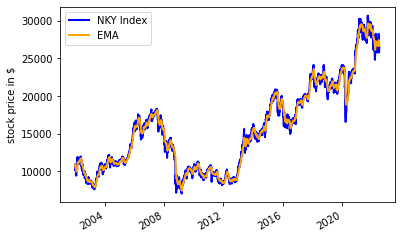

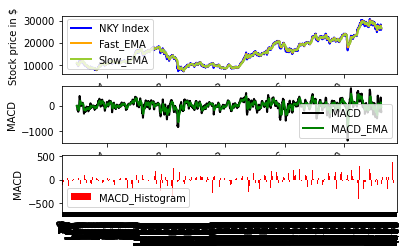

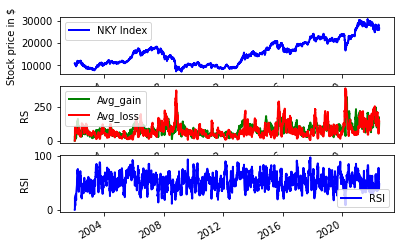

                    0         1         2         3
2002-01-07   0.000000  0.006519  0.000621  0.000000
2002-01-08  22.312124 -0.022551 -0.001599 -2.761247
2002-01-09  20.292054 -0.002956 -0.001726  1.393172
2002-01-10  14.926285 -0.011773 -0.002667  0.832394
2002-01-11  12.397663 -0.009189 -0.003273  0.494594
...               ...       ...       ...       ...
2022-06-20  37.674913 -0.007387 -0.004401  0.542430
2022-06-21  45.186514  0.018435 -0.002317  0.063053
2022-06-22  44.958648 -0.003687 -0.002445  0.060325
2022-06-23  45.821150  0.000830 -0.002140  0.017021
2022-06-24  47.283183  0.012255 -0.000797 -0.110714

[4409 rows x 4 columns]


100%|██████████| 3730/3730 [00:00<00:00, 7365.53it/s]


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 0 train loss: 0.2800397178424256, validation loss:0.11665431410074234


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 1 train loss: 0.02644384148464139, validation loss:0.0028001347091048956


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 2 train loss: 0.0020574001038247453, validation loss:0.0006198828341439366


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 3 train loss: 0.0006894599812637482, validation loss:0.00038354705611709505


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 4 train loss: 0.00042548389423505535, validation loss:0.00026606010214891285


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 5 train loss: 0.00030487084378754456, validation loss:0.00019595582853071392


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 6 train loss: 0.00023082518392974244, validation loss:0.00016105108079500496


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 7 train loss: 0.00019400807546584735, validation loss:0.0001429522380931303


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 8 train loss: 0.0001711393794851444, validation loss:0.00013271573698148131


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 9 train loss: 0.0001555940598336747, validation loss:0.00012235890608280897


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 10 train loss: 0.0001403853493684437, validation loss:0.00011185946277691983


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 11 train loss: 0.00012999834403412284, validation loss:0.00010658036626409739


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 12 train loss: 0.0001235107366872918, validation loss:0.00010150772504857741


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 13 train loss: 0.00011697639976253933, validation loss:9.823737491387874e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 14 train loss: 0.00011224200482372128, validation loss:9.267348286812194e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 15 train loss: 0.00010710063751113401, validation loss:9.00403865671251e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 16 train loss: 0.0001040531482690962, validation loss:8.827244892017916e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 17 train loss: 0.00010187891270366631, validation loss:8.67175476741977e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 18 train loss: 0.00010011802234138096, validation loss:8.550091661163606e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 19 train loss: 9.877696084004128e-05, validation loss:8.39083622850012e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 20 train loss: 9.300200846545132e-05, validation loss:7.866894884500653e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 21 train loss: 8.442638708012444e-05, validation loss:7.395359716610983e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 22 train loss: 8.255056854977738e-05, validation loss:7.203733548521996e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 23 train loss: 7.980797259473807e-05, validation loss:7.148603617679328e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 24 train loss: 7.860018156082203e-05, validation loss:7.100957373040728e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 25 train loss: 7.759837288696352e-05, validation loss:7.069468483678065e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 26 train loss: 7.665124316450342e-05, validation loss:7.070263382047415e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 27 train loss: 7.60106321260017e-05, validation loss:7.068805280141532e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 28 train loss: 7.540500246250303e-05, validation loss:7.045082020340487e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 29 train loss: 7.47784983364649e-05, validation loss:7.02931392879691e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 30 train loss: 7.14991534290935e-05, validation loss:6.666203262284398e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 31 train loss: 6.862379749301388e-05, validation loss:6.373406722559594e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 32 train loss: 6.680687355193575e-05, validation loss:6.370935079758056e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 33 train loss: 6.57411576737234e-05, validation loss:6.375869634211995e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 34 train loss: 6.485982950315312e-05, validation loss:6.363302600220777e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 35 train loss: 6.401097808910501e-05, validation loss:6.355026198434643e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 36 train loss: 6.321855614390058e-05, validation loss:6.336583464872092e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 37 train loss: 6.24658931493676e-05, validation loss:6.314976781141013e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 38 train loss: 6.174320710020506e-05, validation loss:6.287445648922585e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 39 train loss: 6.107996523496695e-05, validation loss:6.257203494897112e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 40 train loss: 6.060913256078493e-05, validation loss:5.727471761929337e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 41 train loss: 6.372903966881236e-05, validation loss:5.53760546608828e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 42 train loss: 6.3886449554827e-05, validation loss:5.47346116945846e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 43 train loss: 6.366542343779915e-05, validation loss:5.4096126405056566e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 44 train loss: 6.355891426730003e-05, validation loss:5.3395349823404104e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 45 train loss: 6.331596361113563e-05, validation loss:5.2829291234957054e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 46 train loss: 6.310917361978292e-05, validation loss:5.242488805379253e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 47 train loss: 6.28571317195435e-05, validation loss:5.225320637691766e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 48 train loss: 6.244581845749053e-05, validation loss:5.234590207692236e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 49 train loss: 6.186448860846992e-05, validation loss:5.2685612899949774e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 50 train loss: 5.949521235899218e-05, validation loss:5.75617013964802e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 51 train loss: 5.282019239010489e-05, validation loss:5.287311978463549e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 52 train loss: 5.2914958944581614e-05, validation loss:5.21365727763623e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 53 train loss: 5.129146757099079e-05, validation loss:5.213083204580471e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 54 train loss: 5.1169287676852294e-05, validation loss:5.215872261032928e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 55 train loss: 5.067578032529647e-05, validation loss:5.19765198987443e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 56 train loss: 5.0368336945081994e-05, validation loss:5.194709592615254e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 57 train loss: 5.008138863818853e-05, validation loss:5.189776129554957e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 58 train loss: 4.9808743889505945e-05, validation loss:5.180419611860998e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 59 train loss: 4.955693605422441e-05, validation loss:5.172247256268747e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 60 train loss: 4.719921298601548e-05, validation loss:5.0625034418771975e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 61 train loss: 4.925301560173726e-05, validation loss:5.1421195166767575e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 62 train loss: 4.8677710570440725e-05, validation loss:5.0021342758554965e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 63 train loss: 4.8290806327193945e-05, validation loss:4.9702364776749164e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 64 train loss: 4.758748160124274e-05, validation loss:4.951193477609195e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 65 train loss: 4.7074984260169526e-05, validation loss:4.9241931264987215e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 66 train loss: 4.659278861903918e-05, validation loss:4.909446943202056e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 67 train loss: 4.6124537480604234e-05, validation loss:4.899850318906829e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 68 train loss: 4.567623649823612e-05, validation loss:4.893023651675321e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 69 train loss: 4.528878428443152e-05, validation loss:4.892443757853471e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 70 train loss: 4.392095888761105e-05, validation loss:5.3804486014996655e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 71 train loss: 4.744038941290845e-05, validation loss:5.5211407016031444e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 72 train loss: 4.69327130433937e-05, validation loss:5.49428350495873e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 73 train loss: 4.636832435218301e-05, validation loss:5.426802999863867e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 74 train loss: 4.604598923054125e-05, validation loss:5.358577618608251e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 75 train loss: 4.55038840690187e-05, validation loss:5.2882729505654424e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 76 train loss: 4.5029161550961104e-05, validation loss:5.210699237068184e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 77 train loss: 4.4564179396339955e-05, validation loss:5.135545325174462e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 78 train loss: 4.408334267022188e-05, validation loss:5.063261778559536e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 79 train loss: 4.361446359065927e-05, validation loss:4.9963862693402916e-05


100%|██████████| 561/561 [00:00<00:00, 3883.19it/s]


평균 0.020930795


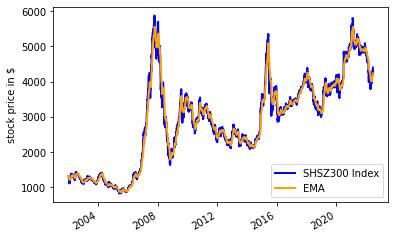

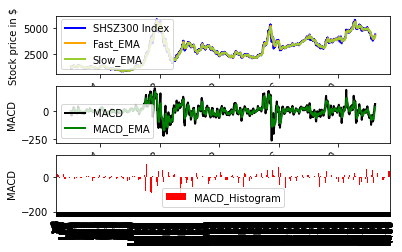

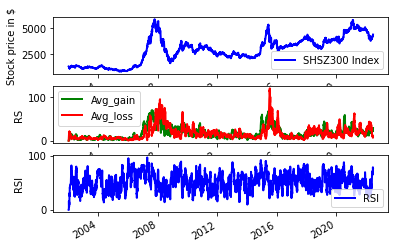

                    0         1         2         3
2002-01-07   0.000000 -0.010923 -0.001040  0.000000
2002-01-08   0.000000 -0.007196 -0.001621  1.372220
2002-01-09   0.000000 -0.015518 -0.002924  0.997422
2002-01-10  16.425029  0.006765 -0.002027  0.224602
2002-01-11  10.265888 -0.024546 -0.004130  0.494596
...               ...       ...       ...       ...
2022-06-20  69.021702  0.004964  0.003886  0.072163
2022-06-21  78.774933 -0.001122  0.003392  0.025096
2022-06-22  71.527216 -0.012704  0.001809 -0.075340
2022-06-23  73.996607  0.017154  0.003296  0.031217
2022-06-24  75.429458  0.011715  0.004123  0.078116

[4409 rows x 4 columns]


100%|██████████| 3730/3730 [00:00<00:00, 7212.86it/s]


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 0 train loss: 0.6200537702866963, validation loss:0.0995635874569416


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 1 train loss: 0.02777679856600506, validation loss:0.0040050712414085865


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 2 train loss: 0.0038078389479778707, validation loss:0.0013790145749226213


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 3 train loss: 0.001395751381226416, validation loss:0.0007553802861366421


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 4 train loss: 0.0007583274803307306, validation loss:0.0005489856412168592


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 5 train loss: 0.0006063331722024097, validation loss:0.0005225289496593177


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 6 train loss: 0.0004467090423401844, validation loss:0.0002873017074307427


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 7 train loss: 0.000359500918420963, validation loss:0.0002724996447796002


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 8 train loss: 0.00029204991681451375, validation loss:0.0002200498929596506


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 9 train loss: 0.0002745172319659365, validation loss:0.00021437793475342914


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 10 train loss: 0.0002365320838829835, validation loss:0.00016868795501068234


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 11 train loss: 0.00021100150453483884, validation loss:0.00015492843522224575


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 12 train loss: 0.00020347977000970526, validation loss:0.00015316896315198392


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 13 train loss: 0.00018683139855316507, validation loss:0.0001467203110223636


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 14 train loss: 0.00017868434692250697, validation loss:0.00014357366308104247


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 15 train loss: 0.00017012136465512282, validation loss:0.00013850750110577792


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 16 train loss: 0.00016401711945945863, validation loss:0.00013411643885774538


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 17 train loss: 0.0001570989994174202, validation loss:0.00012442332445061766


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 18 train loss: 0.0001505763565156875, validation loss:0.00011654543777694926


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 19 train loss: 0.00014415147104175827, validation loss:0.0001090976147679612


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 20 train loss: 0.0001412485562468646, validation loss:0.00011118868860648945


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 21 train loss: 0.00013595218609095485, validation loss:0.0001047970145009458


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 22 train loss: 0.00013182219299778808, validation loss:0.00010167764776269905


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 23 train loss: 0.0001288867403802994, validation loss:9.754021084518172e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 24 train loss: 0.00012676491678575985, validation loss:9.442133523407392e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 25 train loss: 0.00012543616347621928, validation loss:9.141514237853698e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 26 train loss: 0.00012465864191264181, validation loss:8.882620022632182e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 27 train loss: 0.0001243063280916041, validation loss:8.653194163343869e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 28 train loss: 0.00012427100253782037, validation loss:8.485741636832245e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 29 train loss: 0.00012425030555667554, validation loss:8.341746797668748e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 30 train loss: 0.00012986692386870606, validation loss:0.00012448242341633886


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 31 train loss: 0.00011804949060336054, validation loss:0.00010417354860692285


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 32 train loss: 0.00011098939843837538, validation loss:0.00010253939763060771


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 33 train loss: 0.00010634545898418375, validation loss:9.027671330841258e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 34 train loss: 0.00010327270086106312, validation loss:8.67726412252523e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 35 train loss: 0.00010115265260018142, validation loss:8.154723036568612e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 36 train loss: 9.942782967950084e-05, validation loss:7.893731162766926e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 37 train loss: 9.802642437404887e-05, validation loss:7.633938002982177e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 38 train loss: 9.690778279036749e-05, validation loss:7.444400398526341e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 39 train loss: 9.589202818460763e-05, validation loss:7.250280395965092e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 40 train loss: 9.86643412293883e-05, validation loss:9.566226799506694e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 41 train loss: 9.59382743011312e-05, validation loss:8.45941249281168e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 42 train loss: 9.322846978778086e-05, validation loss:8.282524140668102e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 43 train loss: 9.168729073800412e-05, validation loss:7.748540519969538e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 44 train loss: 9.054556241088514e-05, validation loss:7.541837840108201e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 45 train loss: 8.975509886762925e-05, validation loss:7.412077684421092e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 46 train loss: 8.910685340067306e-05, validation loss:7.323543104575947e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 47 train loss: 8.876868014340289e-05, validation loss:7.32218541088514e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 48 train loss: 8.876558266430428e-05, validation loss:7.299349999811966e-05


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 49 train loss: 8.927859939181612e-05, validation loss:7.370826278929599e-05


100%|██████████| 561/561 [00:00<00:00, 7490.14it/s]


평균 0.023818647


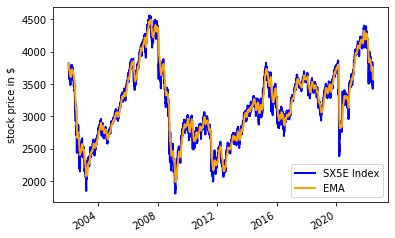

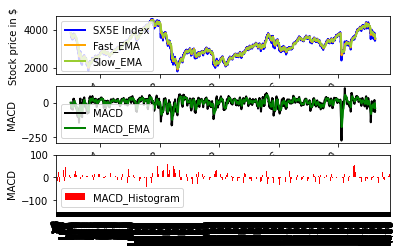

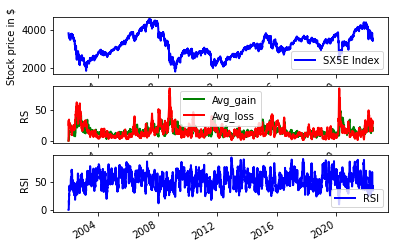

                    0         1         2         3
2002-01-07   0.000000 -0.017276 -0.001645  0.000000
2002-01-08   0.000000 -0.008092 -0.002250  1.180924
2002-01-09   0.000000 -0.000285 -0.002067  0.389432
2002-01-10   0.000000 -0.015208 -0.003293  0.472315
2002-01-11  16.435235  0.008264 -0.002227  0.116224
...               ...       ...       ...       ...
2022-06-20  38.137245  0.009123 -0.004367  0.026652
2022-06-21  42.075059  0.006966 -0.003333 -0.028400
2022-06-22  39.033304 -0.008403 -0.003801 -0.002026
2022-06-23  33.721354 -0.008183 -0.004203  0.016847
2022-06-24  35.672934  0.028193 -0.001241 -0.126773

[4409 rows x 4 columns]


100%|██████████| 3730/3730 [00:00<00:00, 6915.35it/s]


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 0 train loss: 1.3619632537343673, validation loss:0.2859104126691818


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 1 train loss: 0.17931566068104335, validation loss:0.026498470455408096


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 2 train loss: 0.01871189067605883, validation loss:0.00770067167468369


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 3 train loss: 0.005897319576303873, validation loss:0.003509669448249042


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 4 train loss: 0.0026013440302839236, validation loss:0.002233859384432435


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 5 train loss: 0.0017405207701293485, validation loss:0.0019063493236899376


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 6 train loss: 0.0015525626222370192, validation loss:0.001720326952636242


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 7 train loss: 0.0014467414896768918, validation loss:0.0016099073691293597


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 8 train loss: 0.0013613664071142142, validation loss:0.0014437104691751301


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 9 train loss: 0.0012390008695157512, validation loss:0.001270610315259546


100%|██████████| 561/561 [00:00<00:00, 7299.35it/s]


평균 0.13161528


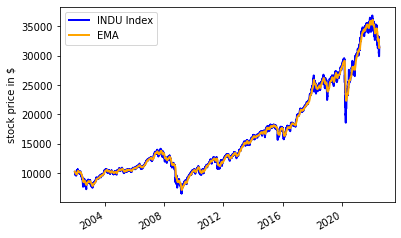

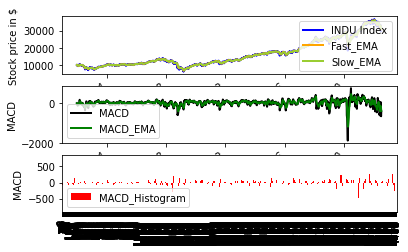

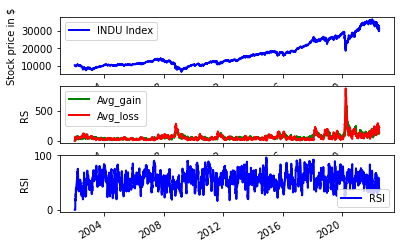

                    0         1         2         3
2002-01-07   0.000000 -0.006110 -0.000582  0.000000
2002-01-08   0.000000 -0.004560 -0.000959  1.462366
2002-01-09   0.000000 -0.005562 -0.001393  0.786518
2002-01-10   0.000000 -0.002599 -0.001506  0.402439
2002-01-11   0.000000 -0.007979 -0.002114  0.401838
...               ...       ...       ...       ...
2022-06-20  35.102558  0.000000 -0.005425  0.061470
2022-06-21  40.407846  0.021639 -0.002981 -0.058154
2022-06-22  38.539286 -0.001634 -0.002856 -0.056515
2022-06-23  35.655106  0.006439 -0.001995 -0.090374
2022-06-24  37.930246  0.026910  0.000706 -0.222456

[4409 rows x 4 columns]


100%|██████████| 3730/3730 [00:00<00:00, 7168.34it/s]


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 0 train loss: 1.1731456145644188, validation loss:0.14055024832487106


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 1 train loss: 0.07495558591160391, validation loss:0.015047426801174879


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 2 train loss: 0.007689135390267309, validation loss:0.0035021286457777023


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 3 train loss: 0.002754952895754416, validation loss:0.0021455258829519153


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 4 train loss: 0.0020220971138249816, validation loss:0.0015432297950610518


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 5 train loss: 0.0014360027375265158, validation loss:0.0011341811623424292


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 6 train loss: 0.0010131020171684213, validation loss:0.0008716670272406191


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 7 train loss: 0.0008374424505745992, validation loss:0.0008161647710949183


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 8 train loss: 0.0008024095877772197, validation loss:0.000732671469449997


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 9 train loss: 0.0006926557949295134, validation loss:0.0005840995872858912


100%|██████████| 561/561 [00:00<00:00, 7102.62it/s]


평균 0.115686305


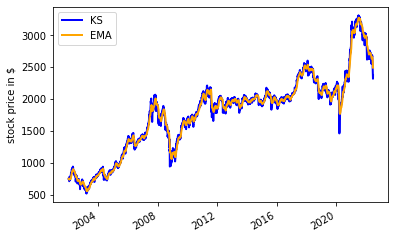

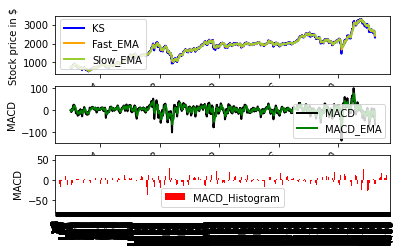

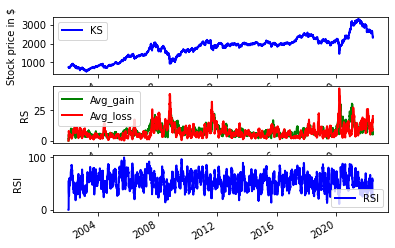

                    0         1         2         3
2002-01-07   0.000000  0.005029  0.000479  0.000000
2002-01-08  18.359375 -0.022249 -0.001696 -3.726188
2002-01-09  55.210287  0.022933  0.000612 -0.652367
2002-01-10  33.948279 -0.031107 -0.002426  5.157814
2002-01-11  33.468659 -0.001195 -0.002312  0.640363
...               ...       ...       ...       ...
2022-06-20  21.973192 -0.020443 -0.006649  0.156445
2022-06-21  27.296412  0.007486 -0.005388  0.052718
2022-06-22  21.912424 -0.027448 -0.007381  0.122501
2022-06-23  20.897679 -0.012161 -0.007804  0.102479
2022-06-24  24.813969  0.022590 -0.005126 -0.015082

[4409 rows x 4 columns]


100%|██████████| 3730/3730 [00:00<00:00, 6902.33it/s]


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 0 train loss: 1.0192984523517745, validation loss:1.1507477164268494


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 1 train loss: 0.3787815147744758, validation loss:0.046406568959355354


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 2 train loss: 0.020892448058085784, validation loss:0.0064857108518481255


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 3 train loss: 0.005076880899391004, validation loss:0.00261173106264323


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 4 train loss: 0.0023761916714387815, validation loss:0.0018619894399307668


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 5 train loss: 0.001546409700365205, validation loss:0.001444588997401297


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 6 train loss: 0.0012811392724480747, validation loss:0.0013344169710762799


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 7 train loss: 0.0011570665540473004, validation loss:0.0011802020017057657


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 8 train loss: 0.0010528479885709072, validation loss:0.0011224114568904042


  0%|          | 0/28 [00:00<?, ?it/s]

epoch: 9 train loss: 0.0009684976685093716, validation loss:0.001083028328139335


100%|██████████| 561/561 [00:00<00:00, 6005.70it/s]


평균 0.07213898


,value,mean_value
index,,
NKY Index,0.012800,0.020931
SHSZ300 Index,0.032048,0.023819
SX5E Index,0.108318,0.131615
INDU Index,0.090633,0.115686
KS,0.038003,0.072139


In [ ]:
columns = ['NKY Index','SHSZ300 Index','SX5E Index','INDU Index','KS']
MSC_list=[]
MSC_mean_list=[]
for i in columns:
 # print(csv_data.loc[:,i])
  ema=EMA(csv_data,i)
  #print(ema)
  #break
  macd,ema_slow=MACD(csv_data,i)
  rs_loss,rs_gain,rsi=RSI(csv_data,i)
  data=pd.concat([rsi,csv_data.loc[:,i].pct_change(),ema.pct_change(),macd.pct_change()],axis=1).dropna()
  data=data.replace((np.inf, -np.inf, np.nan), 0)
  test,test_date=MSC_model_make(data)
  if i =='NKY Index':
    test_pd=test
  else:
    test_pd=pd.concat([test_pd,test],axis=1)
    


k=columns
last_value_pd=pd.DataFrame(MSC_mean_list,MSC_list)
last_value=pd.concat([last_value_pd.reset_index(),pd.DataFrame(k)],axis=1)
last_value.columns=['value','mean_value','index']
last_value.set_index('index')

In [ ]:
test_pd.columns=k
test_pd.index=test_date
test_pd

,NKY Index,SHSZ300 Index,SX5E Index,INDU Index,KS
2019-11-27,1.498082,0.805282,1.170360,1.198525,1.083701
2019-11-29,1.469270,0.790904,1.168410,1.195851,1.052096
2019-12-02,1.451403,0.787858,1.151129,1.174469,1.022688
2019-12-03,1.411768,0.783949,1.133750,1.138700,0.995335
2019-12-04,1.355195,0.793146,1.121603,1.109506,0.964281
...,...,...,...,...,...
2022-06-20,0.804141,1.264266,0.826635,0.782153,0.566721
2022-06-21,0.751289,1.281439,0.827527,0.772756,0.557560
2022-06-22,0.687476,1.276891,0.823896,0.764817,0.541254
2022-06-23,0.629836,1.317774,0.822813,0.765866,0.531224


In [ ]:
test_pd.to_csv('/content/drive/MyDrive/Colab Notebooks/all_country.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
plt.figure(figsize=(16,4))
plt.plot(all_data[-700:,:])
plt.title('Synthetic data')
plt.xlabel('timesteps')
plt.show()

NameError: ignored

<Figure size 1152x288 with 0 Axes>

In [ ]:
val_outputs = []
with torch.no_grad():
    for batch_x, batch_y in val_loader:
        output = model(batch_x.cuda()).detach().cpu().numpy()
        val_outputs.append(output)
val_outputs = np.concatenate(val_outputs, axis=0)

In [ ]:
y_val = y_val.numpy()